# Disease Outbreak Response Decision-making Under Uncertainty: A retrospective analysis of measles in Sao Paulo

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
from datetime import datetime
import matplotlib.pyplot as plt
import pdb

from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
data_dir = "data/"

Import outbreak data

In [3]:
measles_data = pd.read_csv(data_dir+"measles.csv", index_col=0)
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [4]:
measles_data = measles_data.replace({'DISTRICT': {'BRASILANDIA':'BRAZILANDIA'}})

Sao Paulo population by district

In [5]:
sp_pop = pd.read_csv(data_dir+'sp_pop.csv', index_col=0)

In [6]:
_names = sp_pop.index.values
_names[_names=='BRASILANDIA'] = 'BRAZILANDIA'
sp_pop.set_index(_names, inplace = True)

In [7]:
sp_pop.head()

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249
ARICANDUVA,7732,7730,8373,8956,9182,8531,7813,7365,6551,5554,4887,3858,3320,2449,1611,1723,95635
ARTUR ALVIM,9031,9078,10000,11058,11387,10347,9125,8658,7830,7055,5919,4612,3756,2633,1727,1724,113940


Plot of cumulative cases by district

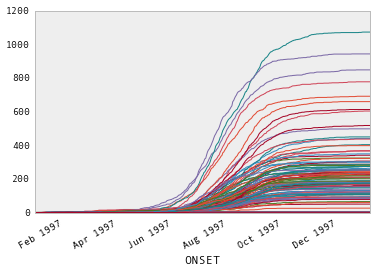

In [8]:
measles_onset_dist = measles_data.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

In [9]:
total_district_cases = measles_onset_dist.sum()

Top 5 districts by number of cases

In [10]:
totals = measles_onset_dist.sum()
totals.sort(ascending=False)
totals[:5]

DISTRICT
GRAJAU             1074
JARDIM ANGELA       944
CAPAO REDONDO       849
JARDIM SAO LUIZ     778
CAMPO LIMPO         692
dtype: float64

Age distribution of cases, by confirmation status

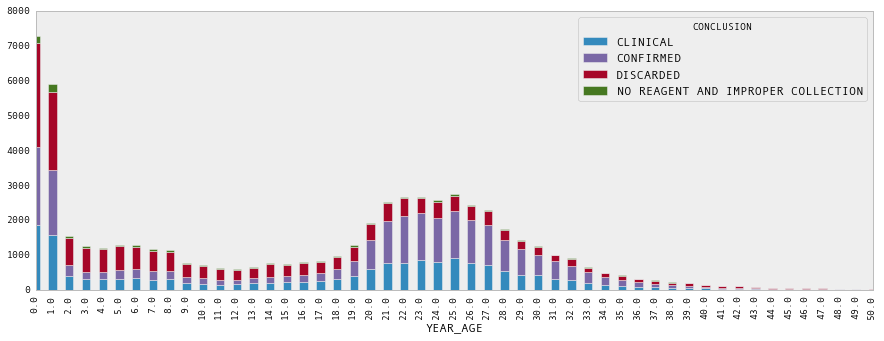

In [11]:
by_conclusion = measles_data.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5))

## Stochastic Disease Transmission Model

As a baseline for comparison, we can fit a model to all the clinically-confirmed cases, regardless of lab confirmation status. For this, we will use a simple SIR disease model, which will be fit using MCMC.

This model fits the series of 2-week infection totals in each district $i$ as a set of Poisson models:

\\[Pr(I(t)_{i} | \lambda(t)_i) = \text{Poisson}(\lambda(t)_i) \\]

Where the outbreak intensity is modeled as:

\\[\lambda(t)_i = \beta [I^{(w)}(t-1)_i]^{\alpha} S(t-1)_i\\]

\\[\alpha \sim \text{Exp}(1)\\]

We will assume here that the transmission rate is constant over time (and across districts):

\\[\beta \sim \text{Gamma}(1, 0.1)\\]

To account for the influence of infected individuals from neighboring districts on new infections, the outbreak intensity was modeled using a spatial-weighted average of infecteds across districts, where populations were weighted as an exponential function of the distance between district centroids:

\\[w_{d} = \text{exp}(-\theta d)\\]

\\[\theta \sim \text{Exp}(1)\\]

### Confirmation Sub-model

Rather than assume all clinical cases are true cases, we can adjust the model to account for lab confirmation probability. This is done by including a sub-model that estimates age group-specific probabilities of confirmation, and using these probabilities to estimate the number of lab-confirmed cases. These estimates are then plugged into the model in place of the clinically-confirmed cases.

We specified a structured confirmation model to retrospectively determine the age group-specific probabilities of lab confirmation for measles, conditional on clinical diagnosis. Individual lab confirmation events $c_i$ were modeled as Bernoulli random variables, with the probability of confirmation being allowed to vary by age group:

$$c_i \sim \text{Bernoulli}(p_{a(i)})$$

where $a(i)$ denotes the appropriate age group for the individual indexed by i. There were 16 age groups, the first 15 of which were 5-year age intervals $[0,5), [5, 10), \ldots , [70, 75)$, with the 16th interval including all individuals 75 years and older.

Since the age interval choices were arbitrary, and the confirmation probabilities of adjacent groups likely correlated, we modeled the correlation structure directly, using a multivariate logit-normal model. Specifically, we allowed first-order autocorrelation among the age groups, whereby the variance-covariance matrix retained a tridiagonal structure. 

$$\begin{aligned}
\Sigma = \left[{
\begin{array}{c}
  {\sigma^2} & {\sigma^2 \rho} & 0& \ldots & {0} & {0}  \\
  {\sigma^2 \rho} & {\sigma^2} &  \sigma^2 \rho & \ldots & {0}  & {0} \\
  {0} & \sigma^2 \rho & {\sigma^2} & \ldots & {0} & {0} \\
  \vdots & \vdots & \vdots &  & \vdots & \vdots\\
  {0} & {0} & 0 & \ldots &  {\sigma^2} & \sigma^2 \rho  \\
{0} & {0} & 0 & \ldots & \sigma^2 \rho &  {\sigma^2} 
\end{array}
}\right]
\end{aligned}$$

From this, the confirmation probabilities were specified as multivariate normal on the inverse-logit scale.

$$ \text{logit}(p_a) = \{a\} \sim N(\mu, \Sigma)$$

Priors for the confirmation sub-model were specified by:

$$\begin{aligned}
\mu_i &\sim N(0, 100) \\
\sigma &\sim \text{HalfCauchy}(25) \\
\rho &\sim U(-1, 1)
\end{aligned}$$

Age classes are defined in 5-year intervals.

In [12]:
age_classes = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,100]
measles_data.dropna(subset=['YEAR_AGE'], inplace=True)
measles_data['YEAR_AGE'] = measles_data.YEAR_AGE.astype(int)
measles_data['AGE_GROUP'] = pd.cut(measles_data.AGE, age_classes, right=False)

Lab-checked observations are extracted for use in estimating lab confirmation probability.

In [13]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

Extract confirmed and clinical subset, with no missing county information.

In [14]:
lab_subset = measles_data[(CONFIRMED | CLINICAL) & measles_data.COUNTY.notnull()].copy()

In [15]:
age = lab_subset.YEAR_AGE.values
ages = lab_subset.YEAR_AGE.unique()
counties = lab_subset.COUNTY.unique()
y = (lab_subset.CONCLUSION=='CONFIRMED').values

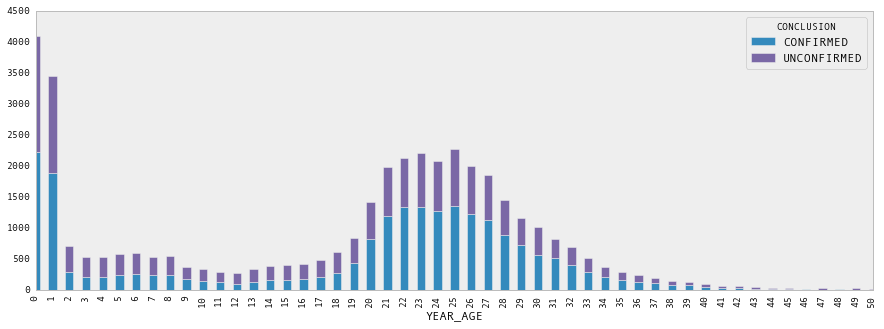

In [16]:
_lab_subset = lab_subset.replace({"CONCLUSION": {"CLINICAL": "UNCONFIRMED"}})
by_conclusion = _lab_subset.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5), grid=False)

In [17]:
lab_subset.shape

(39982, 16)

In [18]:
y.sum()

22097

Proportion of lab-confirmed cases older than 20 years

In [19]:
(measles_data[CONFIRMED].YEAR_AGE>20).mean()

0.60257048468117846

In [20]:
#Extract cases by age and time.

age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.categories.tolist().index(i) for i in age_group])

In [21]:
age_group.categories

Index(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 45)', '[45, 50)', '[50, 55)', '[55, 60)',
       '[60, 65)', '[65, 70)', '[70, 75)', '[75, 100)'],
      dtype='object')

In [22]:
# Get index from full crosstabulation to use as index for each district
dates_index = measles_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().index

In [23]:
unique_districts = measles_data.DISTRICT.dropna().unique()

In [24]:
excludes = ['BOM RETIRO']

In [25]:
N = sp_pop.ix[unique_districts, 'Total'].dropna()
N = N.drop(excludes)

In [26]:
sp_districts = N.index.values
len(sp_districts)

92

Compile bi-weekly confirmed and unconfirmed data by Sao Paulo district

In [27]:
all_district_data = []
all_confirmed_cases = []
for d in sp_districts:

    # All bi-weekly unconfirmed and confirmed cases
    district_data = lab_subset[lab_subset.DISTRICT==d]
    district_counts_2w = district_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).resample('2W', how='sum')
    all_district_data.append(district_counts_2w)

    # All confirmed cases, by district
    confirmed_data = district_data[district_data.CONCLUSION=='CONFIRMED']
    confirmed_counts = confirmed_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).sum()
    all_confirmed_cases.append(confirmed_counts.reindex_axis(measles_data['AGE_GROUP'].unique()).fillna(0))

Time series of cases by district, summarized in 2-week intervals

In [28]:
# Sum over ages for susceptibles
sp_cases_2w = [dist.sum(1) for dist in all_district_data]
len(sp_cases_2w)

92

In [29]:
# Ensure the age groups are ordered
I_obs = np.array([dist.reindex_axis(measles_data['AGE_GROUP'].unique(), 
                            axis=1).fillna(0).values.astype(int) for dist in all_district_data])

In [30]:
I_obs.max()

46

In [31]:
I_obs.sum()

16640

In [32]:
age_groups = np.sort(measles_data['AGE_GROUP'].unique())
age_groups

array(['[0, 5)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 45)', '[45, 50)', '[5, 10)',
       '[50, 55)', '[55, 60)', '[60, 65)', '[65, 70)', '[70, 75)',
       '[75, 100)'], dtype=object)

Check shape of data frame

- 92 districts, 28 bi-monthly intervals, 16 age groups

In [33]:
assert I_obs.shape == (92, 28, 16)

### Spatial distance between districts

In [34]:
import geopandas as gpd

shp = gpd.GeoDataFrame.from_file("Sao Paulo/Brazil_full/BRA_adm3.shp")

In [35]:
district_names = N.index.unique()

In [36]:
import trans
shp['district_name'] = shp.NAME_3.apply(
    lambda x: trans.trans(x).upper())

In [37]:
sp_shp = shp[shp.NAME_2=='São Paulo'].set_index('district_name')

In [38]:
centroids = sp_shp.geometry.centroid

In [39]:
distance_matrix = pd.concat([sp_shp.geometry.distance(o) for o in sp_shp.geometry],
                     axis=1)
distance_matrix.columns = sp_shp.index

In [40]:
assert (distance_matrix.index == centroids.index).all()

In [41]:
distance_matrix = distance_matrix.ix[sp_districts, sp_districts]

In [42]:
assert not distance_matrix.isnull().values.sum()

In [43]:
min_x, min_y = sp_shp.bounds.min()[:2]
max_x, max_y = sp_shp.bounds.max()[2:]

In [44]:
centroid_xy = np.array([[c.x, c.y] for c in sp_shp.geometry.centroid])

Here is an arbitrary distance metric for an arbitrary district, as an example.

In [45]:
_beta = -1
np.exp(_beta*distance_matrix).values.round(2)[0]

array([ 1.  ,  0.97,  0.93,  1.  ,  0.95,  0.93,  0.99,  0.97,  0.85,
        0.98,  0.9 ,  0.9 ,  0.83,  0.92,  1.  ,  0.94,  0.95,  0.99,
        0.84,  0.87,  0.98,  0.84,  0.86,  0.9 ,  0.84,  1.  ,  0.94,
        0.97,  0.93,  0.95,  0.89,  0.84,  0.9 ,  0.86,  0.91,  0.95,
        0.96,  0.91,  0.95,  0.92,  0.87,  0.96,  1.  ,  0.99,  0.9 ,
        0.93,  0.97,  0.91,  0.85,  0.81,  0.87,  0.87,  0.89,  0.84,
        0.95,  0.82,  0.96,  0.96,  1.  ,  0.98,  0.95,  0.99,  0.92,
        0.86,  0.93,  0.98,  0.97,  0.9 ,  0.85,  0.98,  0.99,  0.87,
        0.94,  0.93,  0.89,  0.95,  0.88,  0.86,  0.9 ,  0.89,  0.94,
        0.92,  0.93,  0.88,  0.95,  0.99,  0.96,  0.71,  0.84,  0.94,
        0.91,  1.  ])

Specifying a neighborhood, based on shared borders. This can be used to develop a conditional autoregressive (CAR) model.

In [46]:
neighbors = np.array([sp_shp.ix[district_names].geometry.touches(v).values 
                      for i, v in sp_shp.ix[district_names].geometry.iteritems()])

In [47]:
lon = centroids.ix[district_names].apply(lambda x: x.x)
lat = centroids.ix[district_names].apply(lambda x: x.y)

coords = pd.DataFrame({'x': lon.values-lon.mean(),
              'y': lat.values-lat.mean()}, index=lon.index)

Prior distribution on susceptible proportion:

$$p_s \sim \text{Beta}(2, 100)$$

(array([  3.26800000e+03,   3.48300000e+03,   1.89600000e+03,
          8.17000000e+02,   3.49000000e+02,   1.16000000e+02,
          5.00000000e+01,   1.50000000e+01,   4.00000000e+00,
          2.00000000e+00]),
 array([ 0.00023977,  0.01161644,  0.02299312,  0.0343698 ,  0.04574647,
         0.05712315,  0.06849983,  0.0798765 ,  0.09125318,  0.10262986,
         0.11400653]),
 <a list of 10 Patch objects>)

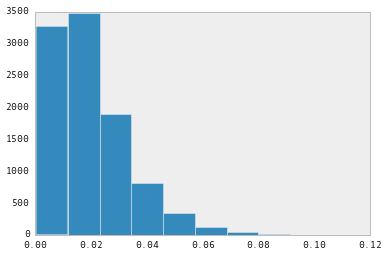

In [48]:
from pymc import rbeta
plt.hist(rbeta(2, 100, 10000))

In [49]:
obs_date = '1997-06-15'
obs_index = all_district_data[0].index <= obs_date
I_obs_t = np.array([I_dist[obs_index] for I_dist in I_obs])

In [50]:
np.sum(I_obs_t, (0,1)) / I_obs_t.sum()

array([ 0.24802706,  0.18038331,  0.21984216,  0.11950395,  0.02029312,
        0.06989853,  0.0011274 ,  0.06087937,  0.06989853,  0.00676437,
        0.00338219,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [51]:
from pymc import MCMC, Matplot
from pymc import (Uniform, DiscreteUniform, Beta, Lambda, Binomial, Normal, 
                  Poisson, NegativeBinomial, observed, negative_binomial_like, poisson_like,
                  Lognormal, Exponential, binomial_like, stochastic, potential, 
                  invlogit, TruncatedNormal, Binomial, Gamma, HalfCauchy, normal_like,
                  deterministic, MvNormalCov, Bernoulli, potential, Uninformative, 
                  Multinomial, rmultinomial, rbinomial, AdaptiveMetropolis,
                  Dirichlet, multinomial_like)

def measles_model(obs_date, confirmation=True, all_traces=False):
    
    n_districts, n_periods, n_age_groups = I_obs.shape
    
    ### Confirmation sub-model
    
    if confirmation:

        # Specify priors on age-specific means
        age_classes = np.unique(age_index)

        mu = Normal("mu", mu=0, tau=0.0001, value=[0]*len(age_classes))
        sig = HalfCauchy('sig', 0, 25, value=1)
        var = sig**2
        cor = Uniform('cor', -1, 1, value=0)

        # Build variance-covariance matrix with first-order correlation 
        # among age classes
        @deterministic
        def Sigma(var=var, cor=cor):
            I = np.eye(len(age_classes))*var
            E = np.diag(np.ones(len(age_classes)-1), k=-1)*var*cor
            return I + E + E.T

        # Age-specific probabilities of confirmation as multivariate normal 
        # random variables
        beta_age = MvNormalCov("beta_age", mu=mu, C=Sigma, 
                        value=[1]*len(age_classes))
        p_age = Lambda('p_age', lambda t=beta_age: invlogit(t))

        @deterministic(trace=False)
        def p_confirm(beta=beta_age):
            return invlogit(beta[age_index])


        # Confirmation likelihood
        lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, value=y, 
                                observed=True)


    '''
    Truncate data at observation period
    '''
    obs_index = all_district_data[0].index <= obs_date
    I_obs_t = np.array([I_dist[obs_index] for I_dist in I_obs])  
                        

    # Index for observation date, used to index out values of interest 
    # from the model.
    t_obs = obs_index.sum() - 1
    
    if confirmation:
        
        @stochastic(trace=all_traces, dtype=int)
        def I(value=(I_obs_t).astype(int), n=I_obs_t, p=p_age):
            # Binomial confirmation process: confirm by age, then re-combine
            
            return np.sum([[binomial_like(value[d,:,a], n[d,:,a], p[a]) 
                            for a in range(n_age_groups)] 
                                for d in range(n_districts)])

    else:
        
        I = I_obs_t
        
    assert I.shape == (n_districts, t_obs +1, n_age_groups)
        
        
    # Calcuate age distribution from observed distribution of infecteds to date
    age_dist = Lambda('age_dist', lambda I=I: np.sum(I, (0,1))/I.sum())

    # Weakly-informative prior on proportion susceptible being 
    # between 0 and 0.07
    p_susceptible = Beta('p_susceptible', 2, 100, size=n_districts)
    
    # Estimated total susceptibles by district
    S_0 = Binomial('S_0', n=N.values.astype(int), p=p_susceptible)

    @deterministic(trace=all_traces)
    def S(I=I, S_0=S_0):
        # Calculate susceptibles from total number of infections
        return np.array([S_0[d] - np.array([I[d,:t].sum() 
                        for t in range(t_obs+1)])
                            for d in range(n_districts)])
    
    assert S.value.shape == (n_districts, t_obs+1)
    
    # Susceptibles at time t, by age
    S_age_init = [rmultinomial(s[-1], age_dist.value) for s in S.value]
    @stochastic(dtype=int)
    def S_age(value=S_age_init, S=S, p=age_dist):
        return sum([multinomial_like(v, s[-1], p) for v,s in zip(value, S)])
    
    assert S_age.shape == (n_districts, n_age_groups)
    
    # Transmission parameter
    β = Gamma('β', 1, 0.1, value=0.001) 
    
#     # CAR component
#     ϕ = Uninformative('ϕ', value=np.zeros(n_districts))
#     τ_car = Exponential('τ_car', 1, value=1)
    
#     @potential
#     def car(ϕ=ϕ, τ=τ_car):
        
#         n = neighbors.sum(0).astype(float)
        
#         return normal_like(ϕ, ϕ.dot(neighbors)/n, n*τ)
    
    θ = Exponential('θ', 1, value=0.01)
    @deterministic
    def Iw(I=I, θ=θ): 
        # Distance-weighted infecteds
        return np.transpose([np.exp(-θ*distance_matrix.values).dot(I_t) for I_t in I.sum(2).T])
    
    assert Iw.value.shape == (n_districts, t_obs+1)
    
    α = Exponential('α', 1, value=1)
    
    # Force of infection
    @deterministic
    def λ(β=β, I=Iw, S=S, α=α): 
        #return np.array([β*((I_d+0.1)**α)*S_d for I_d, S_d in zip(I,S)])
        #return np.array([β*(I_d**α)*S_d for I_d, S_d in zip(I,S)])
        return β*(I**α)*S
    
    assert λ.value.shape == (n_districts, t_obs+1)
    
    # FOI in observation period
    λ_t = Lambda('λ_t', lambda λ=λ: λ[:, -1])
    
    # Poisson likelihood for observed cases
    @potential
    def new_cases(I=I, λ=λ): 
        return poisson_like(I.sum(2)[:,1:], λ[:, :-1])
    
    
    '''
    Vaccination targets
    '''
    
#     @deterministic
#     def vacc_5(S=S_age):
#         # Vaccination of 15 and under
#         p = [0.95] + [0]*15
#         return rbinomial(S.sum(0), p)
    
#     # Proportion of susceptibles vaccinated
#     pct_5 = Lambda('pct_5', 
#                 lambda V=vacc_5, S=S_age: float(V.sum())/S.sum())


#     @deterministic
#     def vacc_15(S=S_age):
#         # Vaccination of 15 and under
#         p = [0.95]*3 + [0]*13
#         return rbinomial(S.sum(0), p)
    
#     # Proportion of susceptibles vaccinated
#     pct_15 = Lambda('pct_15', 
#             lambda V=vacc_15, S=S_age: float(V.sum())/S.sum())
    
#     @deterministic
#     def vacc_30(S=S_age):
#         # Vaccination of 30 and under
#         p = [0.95]*6 + [0]*10
#         return rbinomial(S.sum(0), p)
    
#     # Proportion of 30 and under susceptibles vaccinated
#     pct_30 = Lambda('pct_30', 
#             lambda V=vacc_30, S=S_age: float(V.sum())/S.sum())
    
#     @deterministic
#     def vacc_adult(S=S_age):
#         # Vaccination of adults under 30 (and young kids)
#         p = [0.95, 0, 0, 0, 0.95, 0.95] + [0]*10
#         return rbinomial(S.sum(0), p)
    
#     # Proportion of adults under 30 (and young kids)
#     pct_adult = Lambda('pct_adult', 
#             lambda V=vacc_adult, S=S_age: float(V.sum())/S.sum())

    return locals()

Run models for June 15 and July 15 observation points, both with and without clinical confirmation.

In [52]:
db = 'ram'
n_iterations = 20000
n_burn = 10000

June 15, with lab confirmation

In [53]:
model = measles_model

In [ ]:
model_june = MCMC(model('1997-06-15'), db=db, dbname='model_june')
model_june.use_step_method(AdaptiveMetropolis, model_june.p_susceptible)
model_june.use_step_method(AdaptiveMetropolis, model_june.I)

In [ ]:
model_june.sample(n_iterations, n_burn)

 [--                6%                  ] 1200 of 20000 complete in 235.2 sec

July 15, with lab confirmation

In [104]:
model_july = MCMC(model('1997-07-15'), db=db, dbname='model_july')
# model_july.use_step_method(AdaptiveMetropolis, model_july.S_0)

In [105]:
model_july.sample(n_iterations, n_burn)

 [-----------------100%-----------------] 50000 of 50000 complete in 1309.8 sec

June 15, no lab confirmation

In [106]:
model_june_noconf = MCMC(model('1997-06-15', 
                                       confirmation=False), 
                         db=db, dbname='model_june_noconf')

In [107]:
model_june_noconf.sample(n_iterations, n_burn)

 [-----------------100%-----------------] 50000 of 50000 complete in 463.7 sec

July 15, no lab confirmation

In [108]:
model_july_noconf = MCMC(model('1997-07-15', 
                                       confirmation=False), 
                         db=db, dbname='model_july_noconf')

In [109]:
model_july_noconf.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 505.1 sec

## Summary of model output

Distance weighting parameter for june model with confirmation

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


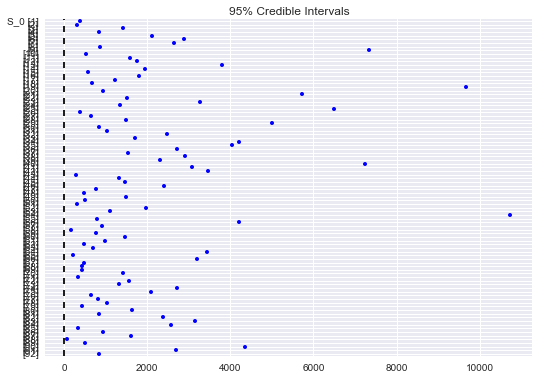

In [110]:
Matplot.summary_plot(model_june.S_0)

Plotting θ


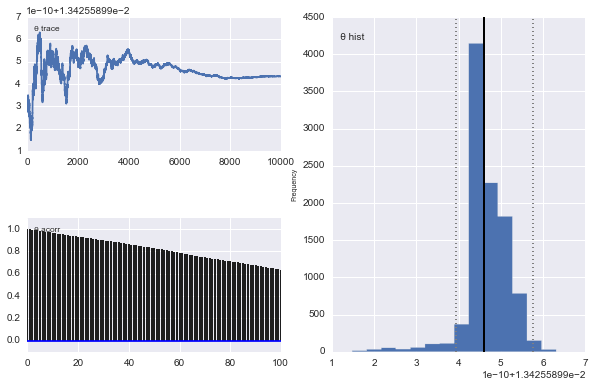

In [111]:
Matplot.plot(model_june.θ)

Lab confirmation rates, June model

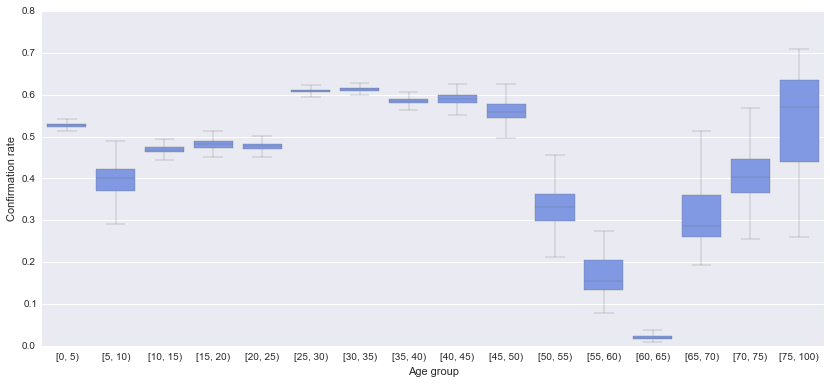

In [112]:
import seaborn as sb

p_age = pd.DataFrame(model_june.p_age.trace(), columns=age_groups)

f, axes = plt.subplots(figsize=(14,6))
sb.boxplot(data=p_age, linewidth=0.3, fliersize=0, ax=axes,
          color=sb.color_palette("coolwarm", 5)[0],
          order=age_group.categories)
axes.set_ylabel('Confirmation rate')
axes.set_xlabel('Age group')

Proportion of population susceptible, June model.

Plotting α


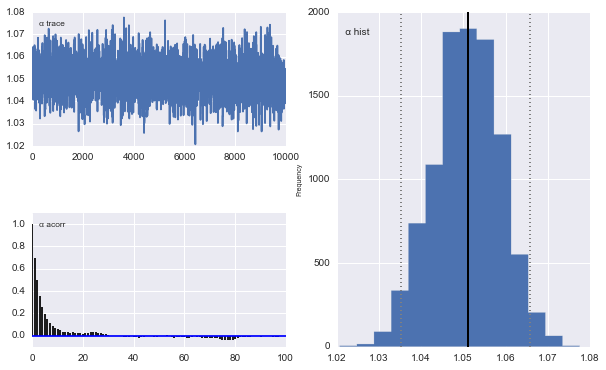

In [113]:
Matplot.plot(model_june.α)

Plotting p_susceptible_0
Plotting p_susceptible_1
Plotting p_susceptible_2
Plotting p_susceptible_3
Plotting p_susceptible_4
Plotting p_susceptible_5
Plotting p_susceptible_6
Plotting p_susceptible_7
Plotting p_susceptible_8
Plotting p_susceptible_9
Plotting p_susceptible_10
Plotting p_susceptible_11
Plotting p_susceptible_12
Plotting p_susceptible_13
Plotting p_susceptible_14
Plotting p_susceptible_15
Plotting p_susceptible_16
Plotting p_susceptible_17
Plotting p_susceptible_18
Plotting p_susceptible_19
Plotting p_susceptible_20
Plotting p_susceptible_21
Plotting p_susceptible_22
Plotting p_susceptible_23
Plotting p_susceptible_24
Plotting p_susceptible_25
Plotting p_susceptible_26
Plotting p_susceptible_27
Plotting p_susceptible_28
Plotting p_susceptible_29
Plotting p_susceptible_30
Plotting p_susceptible_31
Cannot plot autocorrelation for p_susceptible_31
Plotting p_susceptible_32
Plotting p_susceptible_33
Plotting p_susceptible_34
Plotting p_susceptible_35
Plotting p_susceptible_36

KeyboardInterrupt: 

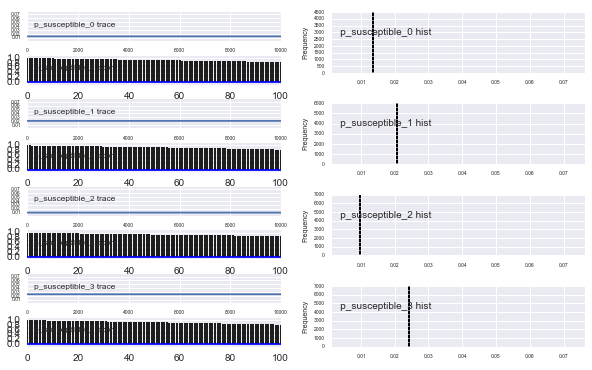

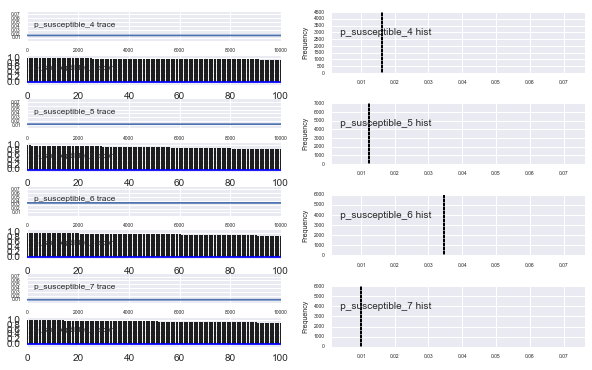

KeyboardInterrupt: 

In [113]:
Matplot.plot(model_june.p_susceptible)

Proportion of population susceptible, June model with no confirmation correction

Plotting p_susceptible


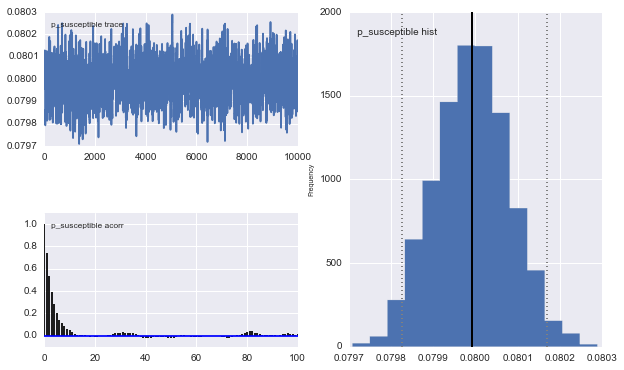

In [66]:
Matplot.plot(model_june_noconf.p_susceptible)

Epidemic intensity estimates at June and July, per district.

ERROR! Session/line number was not unique in database. History logging moved to new session 42
Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


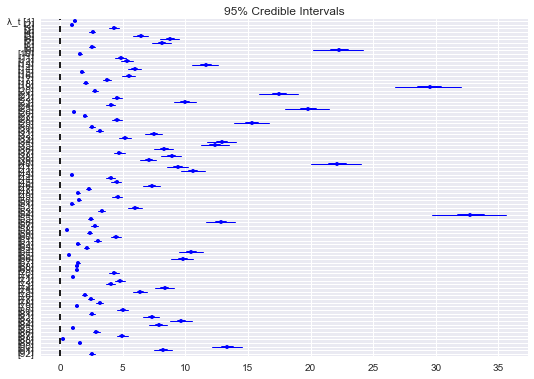

In [114]:
Matplot.summary_plot(model_june.λ_t)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


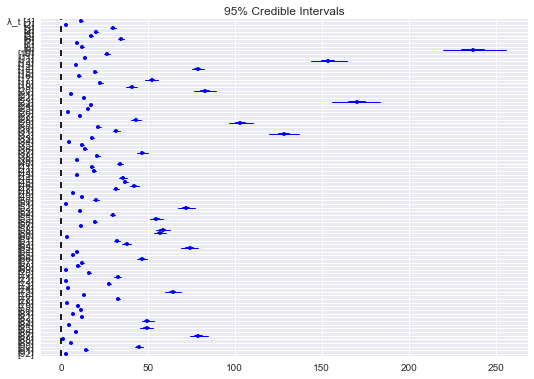

In [115]:
Matplot.summary_plot(model_july.λ_t)

Epidemic intensity for lab- versus clinical-confirmation models

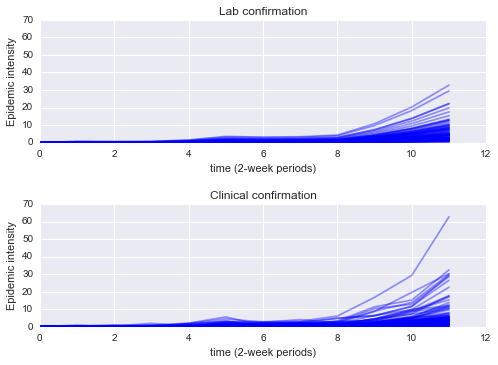

In [116]:
lam_june = model_june.λ.stats()

fig, axes = plt.subplots(2, 1, sharey=True)

axes[0].plot(lam_june['quantiles'][50].T, 'b-', alpha=0.4)
axes[0].set_ylabel('Epidemic intensity')
axes[0].set_xlabel('time (2-week periods)')
axes[0].set_title('Lab confirmation')

lam_june_noconf = model_june_noconf.λ.stats()

axes[1].plot(lam_june_noconf['quantiles'][50].T, 'b-', alpha=0.4)
axes[1].set_ylabel('Epidemic intensity')
axes[1].set_xlabel('time (2-week periods)')
axes[1].set_title('Clinical confirmation')


In [117]:
S_age_june = pd.DataFrame(model_june.S_age.trace()[:, -1], columns=age_groups).unstack().reset_index()
S_age_june.columns = 'Age', 'Iteration', 'S'
S_age_june['Confirmation'] = 'Lab'

In [118]:
S_age_june = pd.DataFrame(model_june.S_age.trace()[:, -1], columns=age_groups).unstack().reset_index()
S_age_june.columns = 'Age', 'Iteration', 'S'
S_age_june['Confirmation'] = 'Lab'

S_age_june_noconf = pd.DataFrame(model_june_noconf.S_age.trace()[:, -1], columns=age_groups).unstack().reset_index()
S_age_june_noconf.columns = 'Age', 'Iteration', 'S'
S_age_june_noconf['Confirmation'] = 'Clinical'

S_age_june = pd.concat([S_age_june, S_age_june_noconf], ignore_index=True)

In [119]:
S_age_july = pd.DataFrame(model_july.S_age.trace()[:, -1], columns=age_groups).unstack().reset_index()
S_age_july.columns = 'Age', 'Iteration', 'S'
S_age_july['Confirmation'] = 'Lab'

S_age_july_noconf = pd.DataFrame(model_july_noconf.S_age.trace()[:, -1], columns=age_groups).unstack().reset_index()
S_age_july_noconf.columns = 'Age', 'Iteration', 'S'
S_age_july_noconf['Confirmation'] = 'Clinical'

S_age_july = pd.concat([S_age_july, S_age_july_noconf], ignore_index=True)

Numbers of suscepibles in each age group, under lab vs clinical confirmation

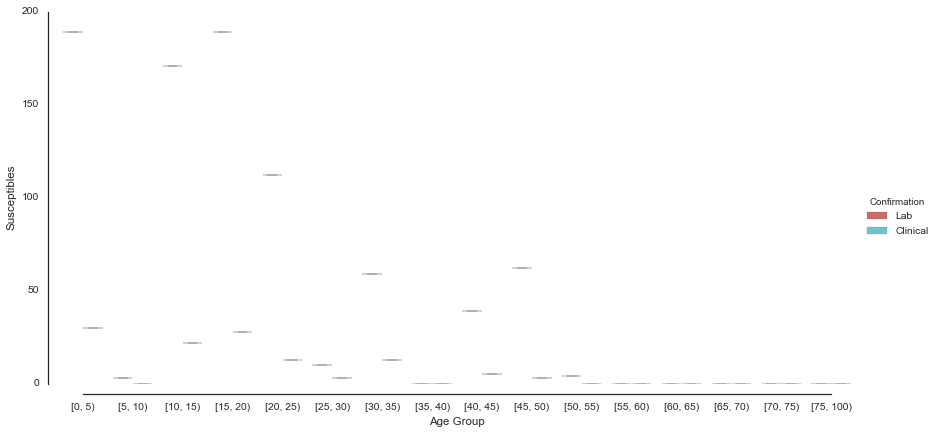

In [120]:
import seaborn as sb
sb.set_context("talk", font_scale=0.8)
sb.set_style("white")

g = sb.factorplot("Age", "S", "Confirmation", S_age_june, kind="box",
                   palette="hls", size=6, aspect=2, linewidth=0.3, fliersize=0, 
                  order=age_group.categories)
g.despine(offset=10, trim=True)
g.set_axis_labels("Age Group", "Susceptibles");

In [121]:
june_lam = pd.DataFrame(model_june.λ_t.trace()).unstack().reset_index()
june_lam.columns = ('district', 'iteration', 'λ')
june_lam['month'] = 'June'

In [122]:
june_lam_noconf = pd.DataFrame(model_june_noconf.λ_t.trace()).unstack().reset_index()
june_lam_noconf.columns = ('district', 'iteration', 'λ')
june_lam_noconf['month'] = 'June'

In [123]:
july_lam = pd.DataFrame(model_july.λ_t.trace()).unstack().reset_index()
july_lam.columns = ('district', 'iteration', 'λ')
july_lam['month'] = 'July'

In [124]:
model_july.S.value.min()

103

In [125]:
july_lam_noconf = pd.DataFrame(model_july_noconf.λ_t.trace()).unstack().reset_index()
july_lam_noconf.columns = ('district', 'iteration', 'λ')
july_lam_noconf['month'] = 'July'

In [126]:
confirmed_lam = june_lam.append(july_lam, ignore_index=True)

In [127]:
june_means = june_lam.groupby('district')['λ'].mean()
june_means.sort(ascending=False)

In [128]:
july_means = july_lam.groupby('district')['λ'].mean()
july_means.sort(ascending=False)

In [129]:
sorted_districts = june_means.index.values

Epidemic intensity by district in June and July (with lab confirmation), sorted by June means.

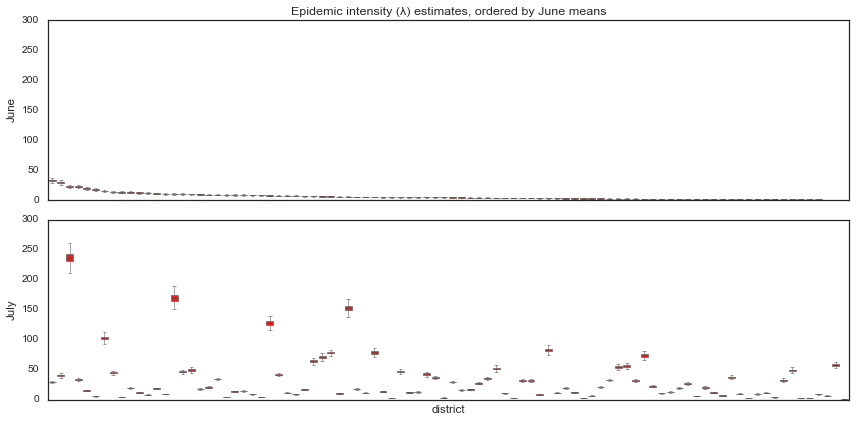

In [130]:
sb.set_context("talk", font_scale=0.8)

f, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(12,6), sharey=True, sharex=True)

sb.boxplot('district', 'λ', data=june_lam, ax=ax_1, linewidth=0.5, 
           fliersize=0, color='r', order=sorted_districts)
# ax_1.hlines(1, xmin=0, xmax=93, linestyles='dashed', linewidth=0.2)
ax_1.set_xticks([])
ax_1.set_xlabel('')
ax_1.set_ylabel('June')
ax_1.set_title(r'Epidemic intensity (λ) estimates, ordered by June means')

sb.boxplot('district', 'λ', data=july_lam, ax=ax_2, linewidth=0.5, 
           fliersize=0, color='r', order=sorted_districts)
# ax_2.hlines(1, xmin=0, xmax=93, linestyles='dashed', linewidth=0.2)
ax_2.set_xticks([])
ax_2.set_ylabel('July')

f.tight_layout()

Epidemic intensity by district in June for lab-confirmed and clinical-confirmed, sorted by lab-confirmed means.

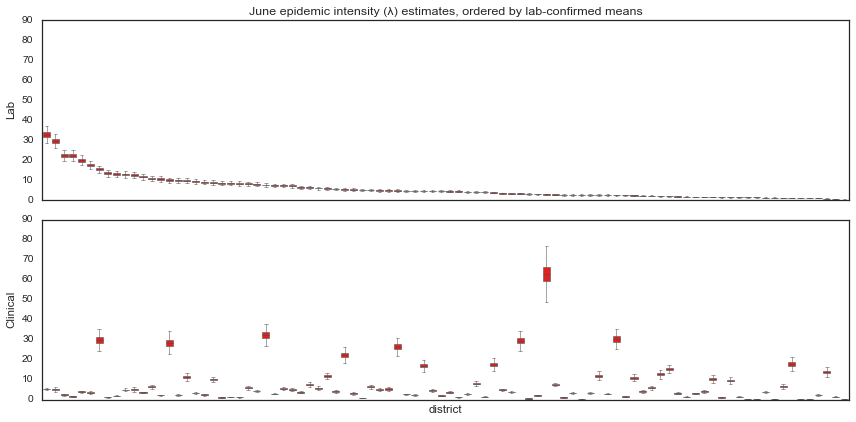

In [131]:
f, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(12,6), sharey=True, sharex=True)

sb.boxplot('district', 'λ', data=june_lam, ax=ax_1, linewidth=0.5, 
           fliersize=0, color='r', order=june_means.index.values)
# ax_1.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_1.set_xticks([])
ax_1.set_xlabel('')
ax_1.set_ylabel('Lab')
ax_1.set_title(r'June epidemic intensity (λ) estimates, ordered by lab-confirmed means')

sb.boxplot('district', 'λ', data=june_lam_noconf, ax=ax_2, linewidth=0.5, 
           fliersize=0, color='r', order=june_means.index.values)
# ax_2.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_2.set_xticks([])
ax_2.set_ylabel('Clinical')

f.tight_layout()

Epidemic intensity by district in July for lab-confirmed and clinical-confirmed, sorted by lab-confirmed means.

In [132]:
july_means = july_lam.groupby('district')['λ'].mean()
july_means.sort(ascending=False)

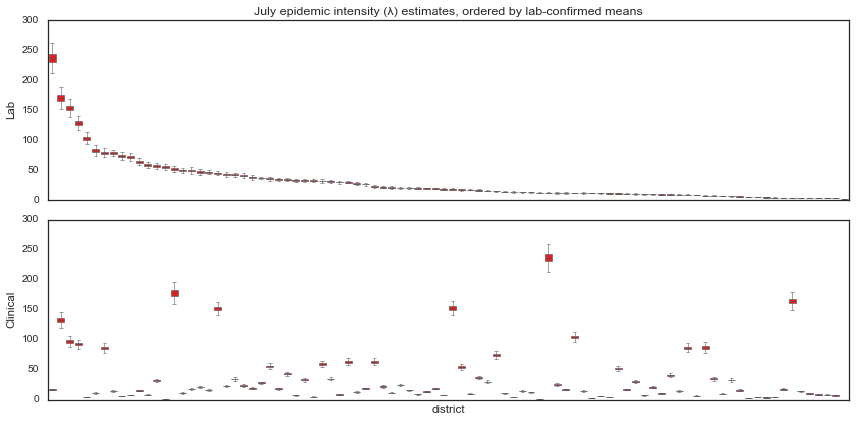

In [133]:
f, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(12,6), sharey=True, sharex=True)

sb.boxplot('district', 'λ', data=july_lam, ax=ax_1, linewidth=0.5, 
           fliersize=0, color='r', order=july_means.index.values)
# ax_1.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_1.set_xticks([])
ax_1.set_xlabel('')
ax_1.set_ylabel('Lab')
# ax_1.set_yticks(np.arange(13, step=2))
ax_1.set_title(r'July epidemic intensity (λ) estimates, ordered by lab-confirmed means')

sb.boxplot('district', 'λ', data=july_lam_noconf, ax=ax_2, linewidth=0.5, 
           fliersize=0, color='r', order=sorted_districts)
# ax_2.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_2.set_xticks([])
ax_2.set_ylabel('Clinical')

f.tight_layout()

In [134]:
foo = np.sum(I_obs[:,:12], (1,2))/N

In [135]:
foo.index = sorted_districts

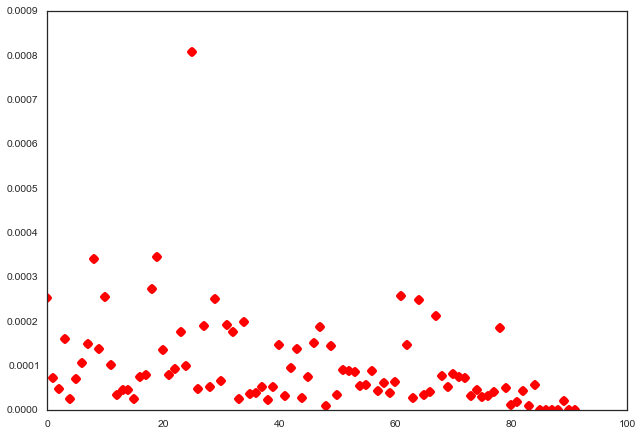

In [136]:
plt.plot(foo, 'ro')

In [137]:
model_june.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.235            0.0              0.0              [ 0.235  0.236]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.235            0.235           0.235          0.235         0.236
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.617            0.0              0.0              [ 0.617  0.618]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.616            0.617           0.617          0.618         0.618
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [138]:
june_coverage = pd.DataFrame({name: model_june.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_coverage['Month'] = 'June'
june_coverage['Confirmation'] = 'Lab'

june_noconf_coverage = pd.DataFrame({name: model_june_noconf.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_noconf_coverage['Month'] = 'June'
june_noconf_coverage['Confirmation'] = 'Clinical'

july_coverage = pd.DataFrame({name: model_july.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_coverage['Month'] = 'July'
july_coverage['Confirmation'] = 'Lab'

july_noconf_coverage = pd.DataFrame({name: model_july_noconf.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_noconf_coverage['Month'] = 'July'
july_noconf_coverage['Confirmation'] = 'Clinical'

In [139]:
coverage = pd.concat([june_coverage, june_noconf_coverage, july_coverage, july_noconf_coverage], 
                     ignore_index=True)

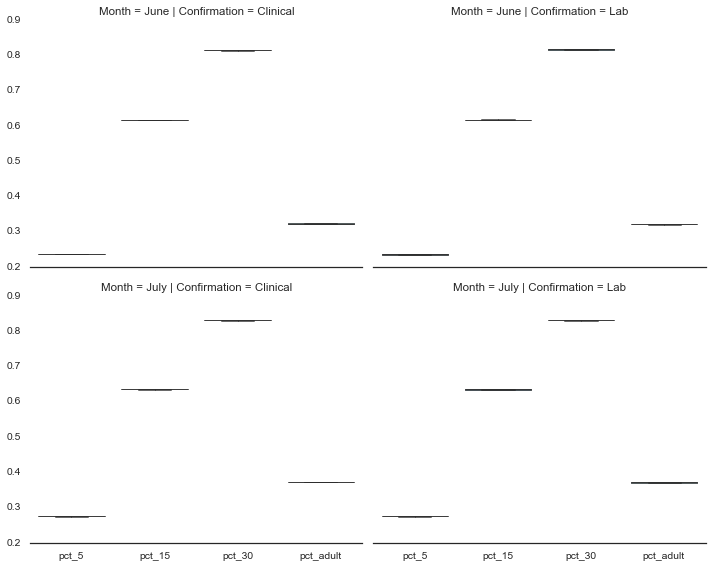

In [140]:
sb.factorplot(row="Month", col="Confirmation", data=coverage, kind='box',
              row_order=['June', 'July'],
              order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'],
               palette="YlGnBu_d", linewidth=0.7, fliersize=0, aspect=1.25).despine(left=True)

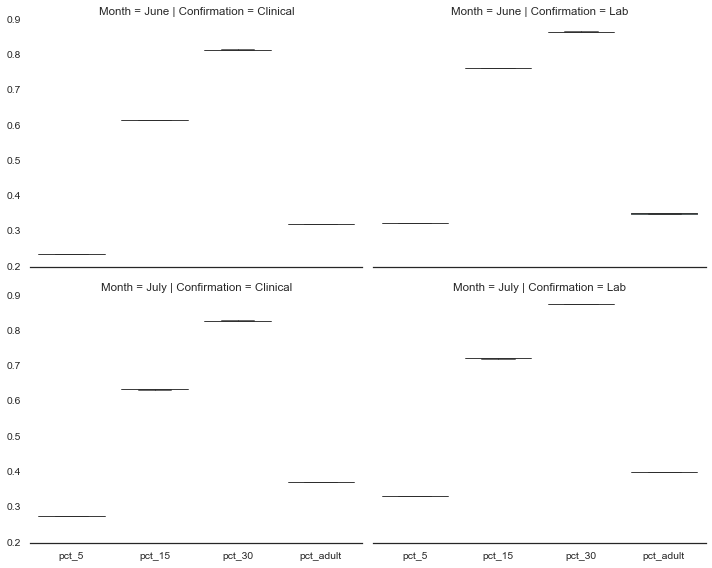

In [94]:
sb.factorplot(row="Month", col="Confirmation", data=coverage, kind='box',
              row_order=['June', 'July'],
              order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'],
               palette="YlGnBu_d", linewidth=0.7, fliersize=0, aspect=1.25).despine(left=True)

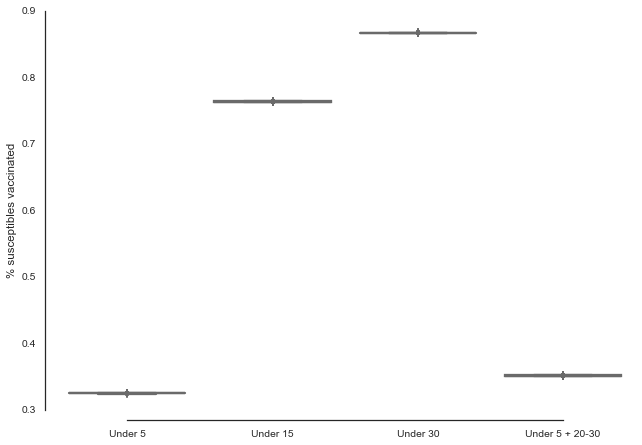

In [95]:
axes = sb.boxplot(data=june_coverage, order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'], 
                  color=sb.color_palette("coolwarm", 5)[0])
axes.set_xticklabels(['Under 5', 'Under 15', 'Under 30', 'Under 5 + 20-30'])
axes.set_ylabel('% susceptibles vaccinated')
sb.despine(offset=10, trim=True)

In [96]:
model_june_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.236            0.0              0.0              [ 0.236  0.236]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.236            0.236           0.236          0.236         0.236
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.616            0.0              0.0              [ 0.616  0.616]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.616            0.616           0.616          0.616         0.616
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [97]:
model_july.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.332            0.0              0.0              [ 0.332  0.332]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.332            0.332           0.332          0.332         0.332
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.722            0.0              0.0              [ 0.722  0.723]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.722            0.722           0.722          0.722         0.723
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [98]:
model_july_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.275            0.0              0.0              [ 0.275  0.275]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.275            0.275           0.275          0.275         0.275
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.635            0.0              0.0              [ 0.634  0.635]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.634            0.634           0.635          0.635         0.635
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [99]:
Rt_july = model_july.Rt.stats()

AttributeError: 'MCMC' object has no attribute 'Rt'

In [ ]:
plt.plot(Rt_july['quantiles'][50].T, 'b-', alpha=0.4)
plt.ylabel('R(t)')
plt.xlabel('time (2-week periods)')

In [ ]:
Rt_june_noconf = model_june_noconf.Rt.stats()

In [ ]:
plt.plot(Rt_june_noconf['quantiles'][50].T, 'b-', alpha=0.4)
plt.ylabel('R(t)')
plt.xlabel('time (2-week periods)')

In [ ]:
Matplot.summary_plot(model_june.p_age)

In [ ]:
june_age_dist = model_june.age_dist.trace()[:]
june_age_dist.shape

In [ ]:
june_age_dist = pd.DataFrame(june_age_dist, columns=measles_data['AGE_GROUP'].unique())

In [ ]:
plt.figure(figsize=(8,12))
Matplot.summary_plot(model_july.vaccination_target)

In [ ]:
plt.figure(figsize=(8,12))
Matplot.summary_plot(model_july.vaccination_target)

## Mapping spatial effects

In [ ]:
from mpl_toolkits.basemap import Basemap
import geopandas as gpd

lllat=-24
urlat=-23.3
lllon=-47
urlon=-46.3

SP_base = Basemap(ax=None, lon_0=(urlon + lllon) / 2, lat_0=(urlat + lllat) / 2,
        llcrnrlat=lllat, urcrnrlat=urlat, llcrnrlon=lllon, urcrnrlon=urlon, 
                  resolution='i',
                 epsg='4326')

In [ ]:
SP_dist = gpd.GeoDataFrame.from_file('Sao Paulo/Brazil_full/BRA_adm3.shp').to_crs({'proj': 'longlat', 
                                                                               'ellps': 'WGS84', 
                                                                               'datum': 'WGS84'})

In [ ]:
SP_dist['DIST_NAME'] = [trans.trans(_).upper() for _ in SP_dist.NAME_3]

In [ ]:
λ_june = pd.Series(model_june.λ_t.stats()['mean'], index=sp_districts)

In [ ]:
λ_june

In [ ]:
SP_dist_merged = SP_dist.merge(pd.DataFrame(λ_june, columns=['λ']), left_on='DIST_NAME', right_index=True)

In [ ]:
measles_onset_conf = measles_data[CONFIRMED].groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0).sum()

In [ ]:
measles_onset_conf

In [ ]:
_rates = measles_onset_conf/sp_pop.sum(1)

In [ ]:
SP_dist_conf = SP_dist.merge(pd.DataFrame(_rates, columns=['rate']), left_on='DIST_NAME', right_index=True)

In [ ]:
from matplotlib.pyplot import cm

map_fig = plt.figure(figsize=(16,12))
map_ax = plt.gca()
SP_base.drawcoastlines()
SP_base.drawrivers()

SP_dist_merged.plot(column='λ', colormap=cm.Reds, axes=map_ax)

In [ ]:
map_fig = plt.figure(figsize=(16,12))
map_ax = plt.gca()
SP_base.drawcoastlines()
SP_base.drawrivers()

SP_dist_conf.plot(column='rate', colormap=cm.Reds, axes=map_ax)